Notebook to sketch methodology for occultation flagging.

TODO: What is an acceptble false positive rate?

TODO: approach is definitely parallisable

TODO: save (and load) template bank

TODO: subtract sky backgrounds

TODO: be sensible about what templates to trial on a source of a given brightness (save time)

Automate the workflow:

- Is it wise to blindly implement comparison star selection... probably not

In [1]:
# imports
from tqdm import tqdm # progressbar
import os
import numpy as np
from astropy.stats import mad_std
import matplotlib.pyplot as plt
%matplotlib inline

### Differential photometry

In [2]:
# load data and generate a matrix of observations
path = 'E:/McDonald backups/results_M11_Sept20_2'

files = [f for d, s, f in os.walk(path)][0]

# order the files
phot_files = []
seq_files = []
sky_files = []
batch_ids = np.arange(0, 1000).astype(str)
for b in batch_ids:
    for f in files:
        if 'photometry' in f and 'batch' + b + '.npy' in f:
            phot_files.append(f)
        elif 'seq' in f and 'batch' + b + '.npy' in f:
            seq_files.append(f)
        elif 'sky' in f and 'batch' + b + '.npy' in f:
            sky_files.append(f)

In [3]:
positions = np.load(os.path.join(path, 'positions.npy'))
bb_pos = np.load(os.path.join(path, 'bb_pos.npy'))
positions.shape, bb_pos.shape

((282, 2), (8, 2))

In [4]:
n = 0 # use as reference for array dimensions
fs = np.load(os.path.join(path, phot_files[n])) # use for shape info
ss = np.load(os.path.join(path, sky_files[n]))
data = np.zeros((len(phot_files), fs.shape[0], fs.shape[1])) # data matrix
t = np.zeros((len(seq_files), fs.shape[0])) # observation sequence numbers (i.e. time)
bkgs = np.zeros((len(sky_files), ss.shape[0], ss.shape[1]))

# staple together the data in files
def batch_files(files, arr):
    for i,file in enumerate(files):
        arr[i] = np.load(os.path.join(path, file))
    return arr

data = batch_files(phot_files, data)
t = batch_files(seq_files, t)
bkgs = batch_files(sky_files, bkgs)

In [5]:
# reshape and change dtype
data = data.reshape(data.shape[0] * data.shape[1], data.shape[2]).astype(np.float32)
bkgs = bkgs.reshape(bkgs.shape[0] * bkgs.shape[1], bkgs.shape[2]).astype(np.float32)
t = t.flatten().astype(np.float32)
data.shape, data.dtype, t.shape, t.dtype, bkgs.shape, bkgs.dtype

((290000, 282),
 dtype('float32'),
 (290000,),
 dtype('float32'),
 (290000, 8),
 dtype('float32'))

In [6]:
# generate observatons matrix (n_samples x n_features)
X = np.copy(data)
X.shape

(290000, 282)

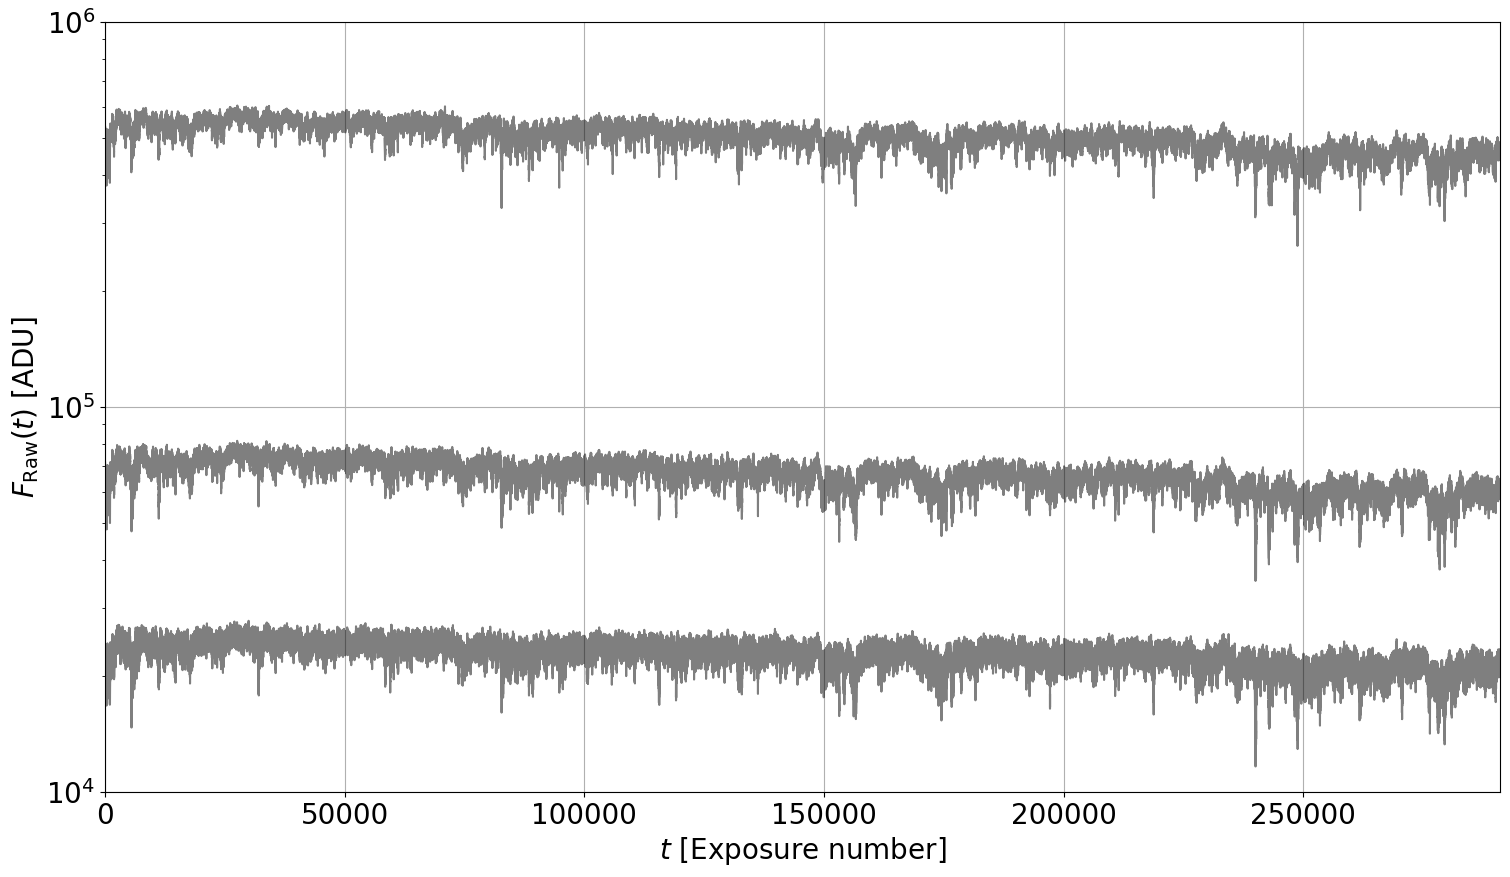

In [9]:
# by-eye check - should see co-trending behaviour
fs = 20
plt.figure(figsize=(18,10))
stars = [0, 1, 25]
plt.plot(t, X[:, stars], c='black', alpha=0.5)
plt.ylabel('$F_{\mathrm{Raw}}(t)$ [ADU]', fontsize=fs)
plt.xlabel('$t$ [Exposure number]', fontsize=fs)
plt.tick_params(labelsize=fs)
plt.xlim(0, t[-1])
plt.ylim(1e4, 1e6)
plt.yscale('log')
plt.grid()
plt.savefig('figures/Raw_timeseries.png', bbox_inches='tight')

In [10]:
# normalise light curves
X_norm = X / np.median(X, axis=0)
X_norm.shape

(290000, 282)

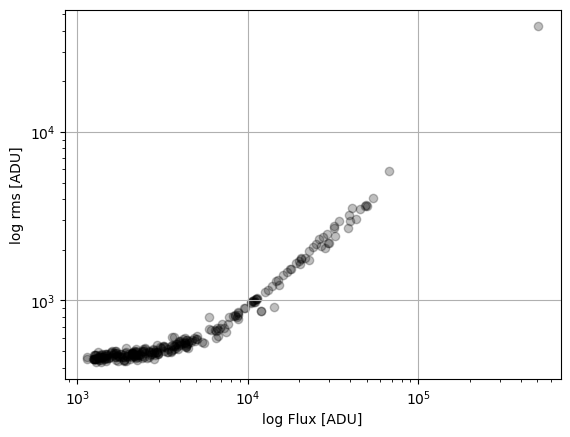

In [11]:
# plot of std vs median flux
plt.scatter(np.median(X, axis=0), np.std(X, axis=0)[:, None], alpha=0.25, c='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log Flux [ADU]')
plt.ylabel('log rms [ADU]')
plt.grid();

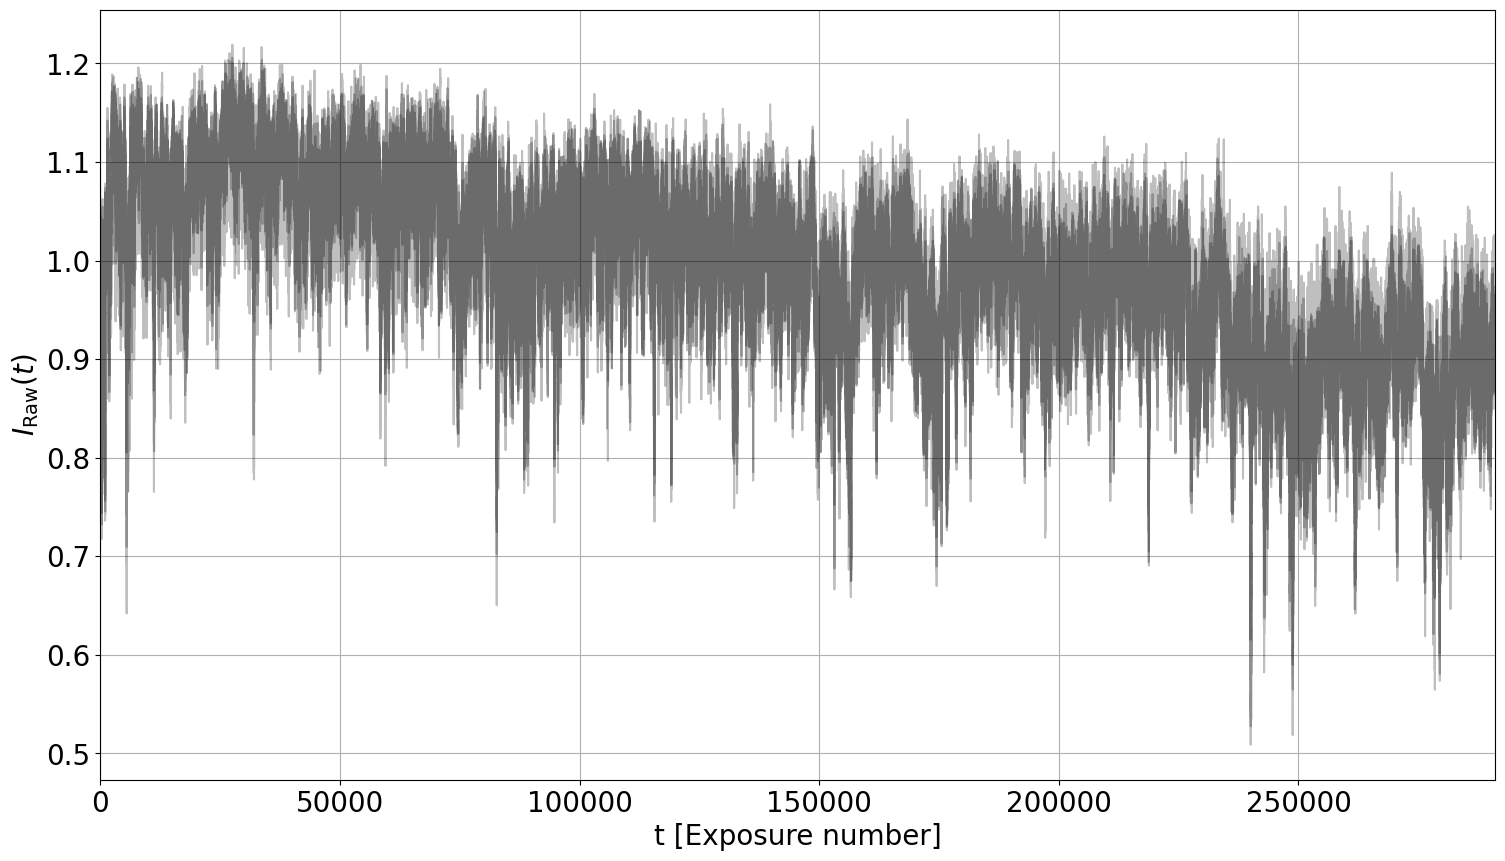

In [13]:
plt.figure(figsize=(18,10))
plt.plot(t, X_norm[:, stars], c='black', alpha=0.25)
plt.ylabel('$I_{\mathrm{Raw}}(t)$', fontsize=fs)
plt.xlabel('t [Exposure number]', fontsize=fs)
plt.tick_params(labelsize=fs)
plt.xlim(0, t[-1])
plt.grid()
plt.savefig('figures/Normalised_timeseries.png', bbox_inches='tight')

Number of comparison stars: 72


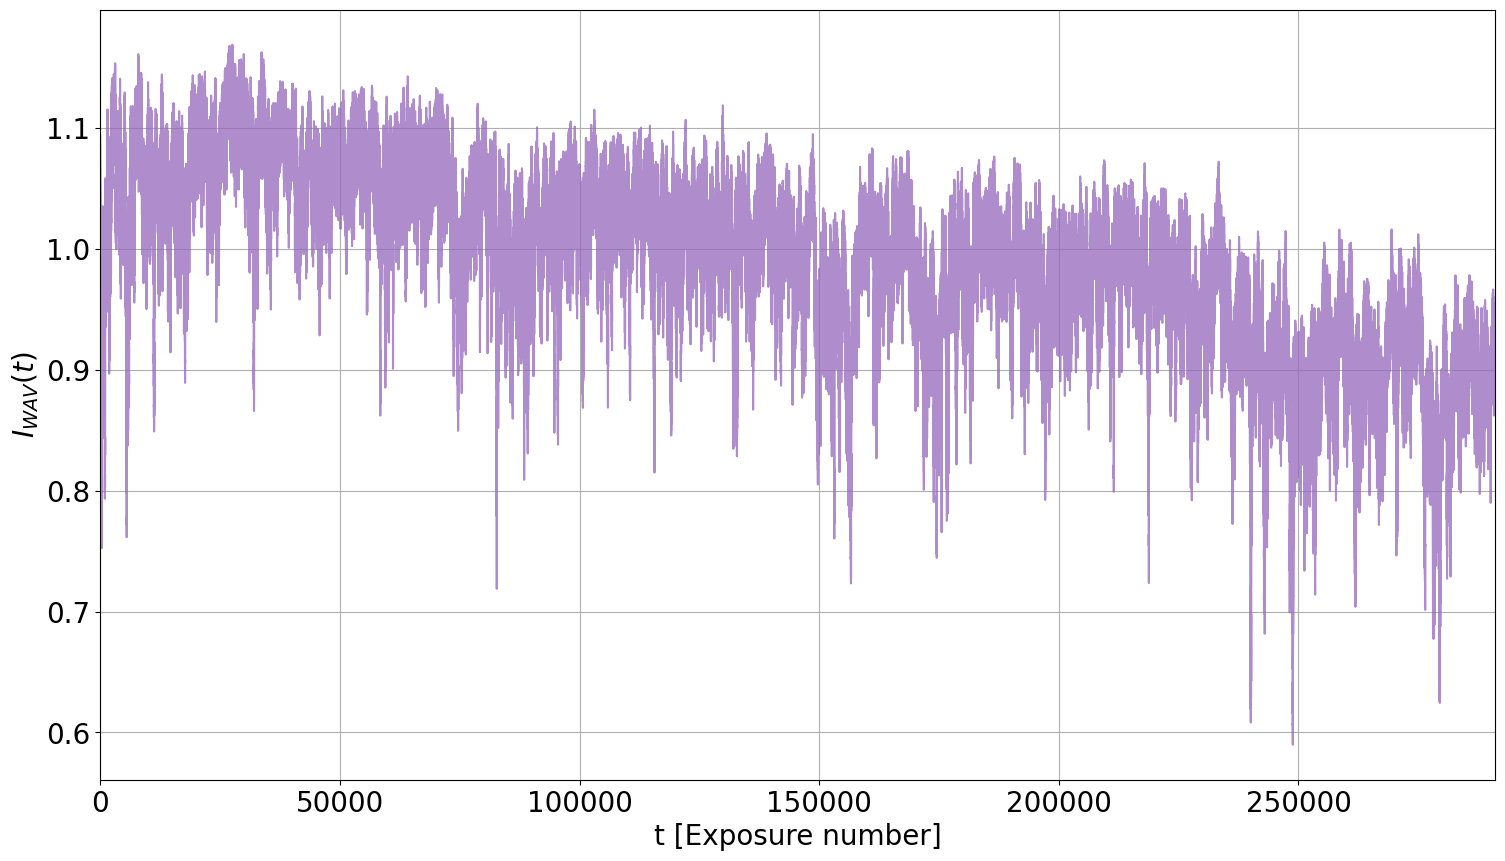

In [16]:
comparison_stars = np.where(np.std(X_norm[:, :], axis=0) < 0.1)[0]
print("Number of comparison stars:", len(comparison_stars))
wav = np.average(X_norm[:, comparison_stars],
                 weights=1./np.var(X_norm[:, comparison_stars], axis=0), axis=1)

plt.figure(figsize=(18,10))
plt.plot(t, wav, c='tab:purple', alpha=0.75)
plt.ylabel('$I_{WAV}(t)$', fontsize=fs)
plt.xlabel('t [Exposure number]', fontsize=fs)
plt.tick_params(labelsize=fs)
plt.xlim(0, t[-1])
plt.grid()
plt.savefig('figures/wav.png', bbox_inches='tight')

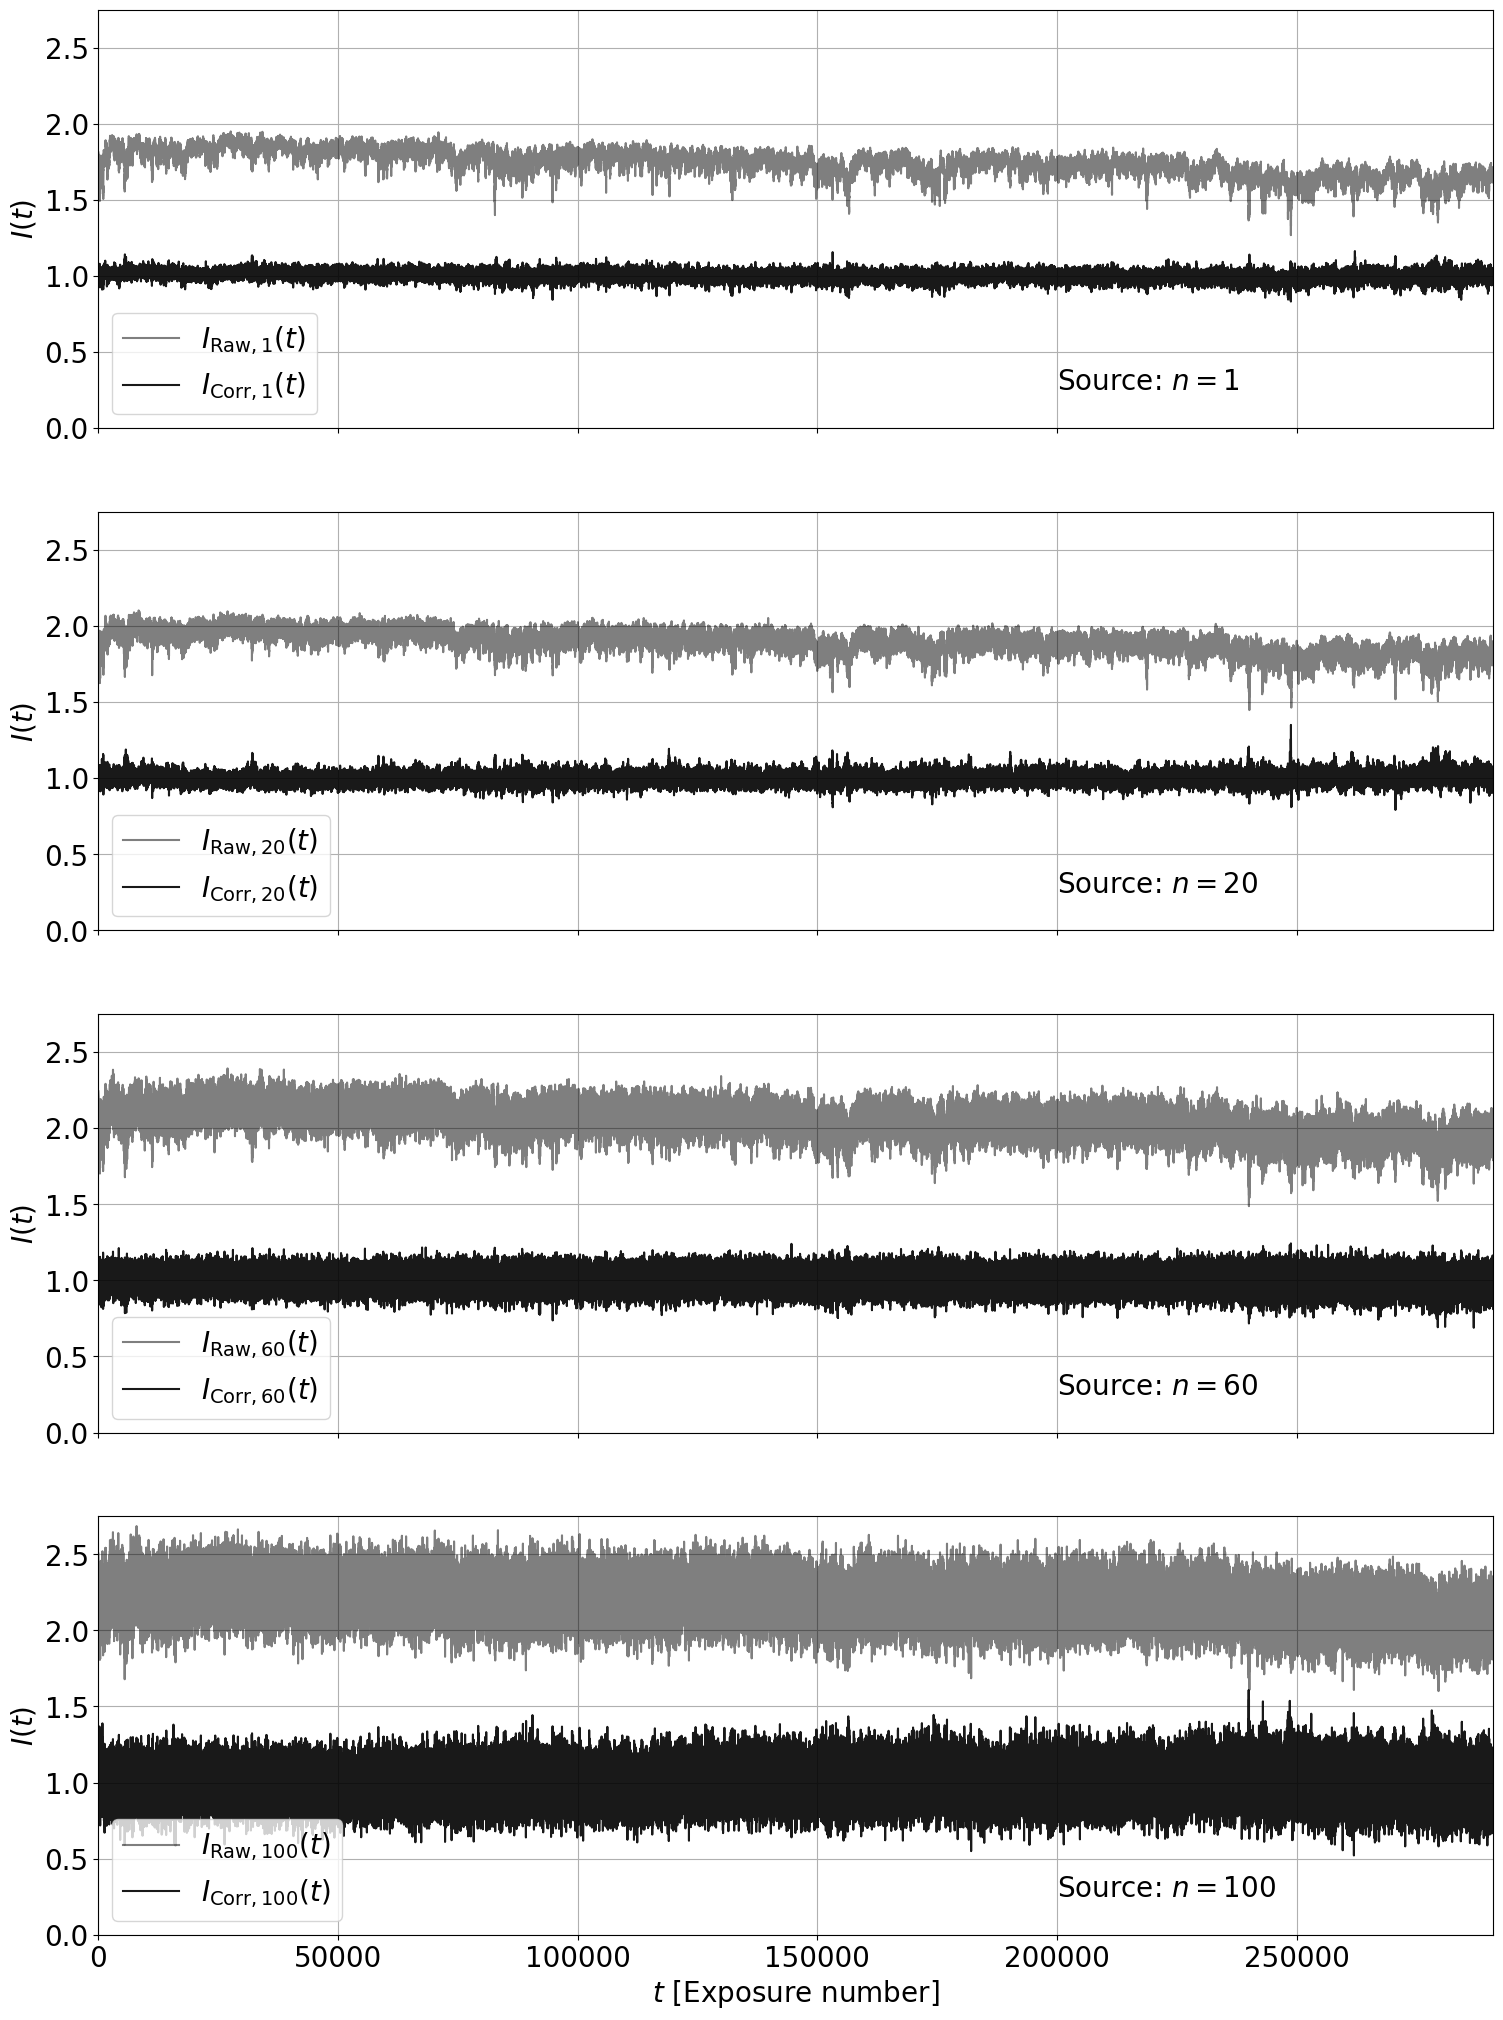

In [18]:
samples = [0, 19, 59, 99]
nrows = 4
fig, ax = plt.subplots(figsize=(18, 25), nrows=nrows, ncols=1)
for i in range(nrows):
    
    # if the sample is in the comparison star set, exclude it
    comparison_stars = np.where(np.std(X_norm[:, :], axis=0) < 0.1)[0]
    comparison_stars = [c for c in comparison_stars if c != samples[i]]
    wav = np.average(X_norm[:, comparison_stars],
                     weights=1./np.var(X_norm[:, comparison_stars], axis=0), axis=1)
    
    ax[i].plot(t, (0.75 + 0.15*i) + (X_norm[:, samples[i]]), c='black', alpha=0.5,
               label='$I_{\mathrm{Raw}, %d}(t)$' % (samples[i] + 1))
    ax[i].plot(t, X_norm[:, samples[i]] / wav, c='black', alpha=0.9,
               label='$I_{\mathrm{Corr}, %d}(t)$' % (samples[i] + 1))
    ax[i].grid()
    ax[i].legend(loc='lower left', fontsize=fs)
    ax[i].text(200000, 0.25, 'Source: $n=%d$' % (samples[i] + 1), fontsize=fs)
    ax[i].set_xlim(0, t[-1])
    ax[i].set_ylim(0, 2.75)
    ax[i].tick_params(labelsize=fs)
    
    ax[i].set_ylabel('$I(t)$', fontsize=fs)
    
    if i != 3:
        ax[i].axes.xaxis.set_ticklabels([])
    
    if i == 3:
        ax[i].set_xlabel('$t$ [Exposure number]', fontsize=fs)
        
        
plt.savefig('figures/Raw_vs_Corr.png', bbox_inches='tight')